# Test immapp.nb Notebook Convenience API

This notebook tests the new `immapp.nb` module that provides non-blocking GUI execution for Jupyter notebooks.

In [1]:
# Import imgui_bundle
from imgui_bundle import immapp, imgui, hello_imgui
import asyncio

## Test 1: Basic start() with gui_function

In [2]:
# Define a simple GUI function
counter = {"value": 0}

def my_gui():
    params = hello_imgui.get_runner_params()

    params.fps_idling.fps_idling_mode = hello_imgui.FpsIdlingMode.early_return # Use early return mode
    params.fps_idling.vsync_to_monitor = False # Disable vsync which is implemented via sleep
    params.fps_idling.fps_max = 60.0 # Limit to 60 FPS (otherwise we may run at 500+ FPS on fast machines)

    imgui.text(f"Counter: {counter['value']}")
    if imgui.button("Increment"):
        counter["value"] += 1
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True
    
    imgui.text(f"FPS: {hello_imgui.frame_rate():.2f}")

In [3]:
# Start the GUI non-blocking
immapp.nb.start(my_gui, window_title="Test Counter", window_size_auto=True)

<Task pending name='Task-31' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/immapp/run_async_overloads.py:63>>

In [4]:
# Check if GUI is running
print(f"GUI running: {immapp.nb.is_running()}")

GUI running: True


In [5]:
# Modify counter while GUI is running
counter["value"] = 100
print("Counter updated to 100 - check GUI window!")

Counter updated to 100 - check GUI window!


In [6]:
# Stop the GUI programmatically
immapp.nb.stop()
print("GUI stopped")

GUI stopped


## Test 2: start() with SimpleRunnerParams

In [7]:
# Test with SimpleRunnerParams
def another_gui():
    imgui.text("This is a simple GUI")
    imgui.text("Using SimpleRunnerParams")
    if imgui.button("Exit"):
        hello_imgui.get_runner_params().app_shall_exit = True

simple_params = hello_imgui.SimpleRunnerParams()
simple_params.gui_function = another_gui
simple_params.window_title = "Simple GUI"
simple_params.top_most = True

immapp.nb.start(simple_params)

<Task pending name='Task-44' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/immapp/run_async_overloads.py:63>>

In [8]:
# Stop it
immapp.nb.stop()

## Test 3: start() with RunnerParams + AddOnsParams (ImPlot)

In [9]:
import math
from imgui_bundle import implot, immapp, imgui, hello_imgui
import numpy as np

# Create a GUI with ImPlot
plot_data = {"x": [], "y": []}
for i in range(100):
    plot_data["x"].append(i * 0.1)
    plot_data["y"].append(math.sin(i * 0.1))

plot_data["x"] = np.array(plot_data["x"], dtype=np.float32)
plot_data["y"] = np.array(plot_data["y"], dtype=np.float32) 

def plot_gui():
    imgui.text("ImPlot Example")
    if implot.begin_plot("Sin Wave"):
        implot.plot_line("sin(x)", plot_data["x"], plot_data["y"])
        implot.end_plot()
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True

runner_params = hello_imgui.RunnerParams()
runner_params.callbacks.show_gui = plot_gui
runner_params.app_window_params.window_title = "Plot GUI"
runner_params.app_window_params.top_most = True

addons = immapp.AddOnsParams()
addons.with_implot = True

immapp.nb.start(runner_params, addons)
# immapp.run(runner_params, addons)

<Task pending name='Task-51' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/immapp/run_async_overloads.py:63>>

In [10]:
# Update plot data while running
plot_data["y"] = np.array([math.cos(x) for x in plot_data["x"]])
print("Plot updated to cos(x) - check the window!")

Plot updated to cos(x) - check the window!


In [11]:
# Stop
immapp.nb.stop()

## Test 4: Auto-stop when starting new GUI

In [12]:
# Start first GUI
def gui1():
    imgui.text("This is GUI #1")

immapp.nb.start(gui1, window_title="GUI 1")
print("GUI 1 started")

GUI 1 started


In [13]:
# Start second GUI - should auto-stop first one with warning
def gui2():
    imgui.text("This is GUI #2")

immapp.nb.start(gui2, window_title="GUI 2")
print("GUI 2 started (GUI 1 should have been auto-stopped)")

GUI 2 started (GUI 1 should have been auto-stopped)


In [14]:
# Clean up
immapp.nb.stop()

## Performance Test: Async Parallel Execution

This test demonstrates the performance benefit of async mode with optimized FPS settings.
The GUI runs in parallel with a Python loop that performs computations.

In [20]:
import time

# Performance monitoring
perf_data = {
    "iterations": 0,
    "last_time": time.time(),
    "fps": 0.0
}

def gui_edit_idling_params():
    imgui.separator_text("FPS Idling Settings")
    imgui.text("Below, you can adjust the FPS idling parameters. Performance may drop")
    params_idling = hello_imgui.get_runner_params().fps_idling

    # Enable FPS idling
    _, params_idling.enable_idling = imgui.checkbox("Enable FPS Idling", params_idling.enable_idling)

    # Idling mode
    idling_mode = params_idling.fps_idling_mode
    modes = [hello_imgui.FpsIdlingMode.sleep, hello_imgui.FpsIdlingMode.early_return]
    mode_names = ["Sleep", "Early Return"]
    current_mode_index = modes.index(idling_mode)
    changed, new_mode_index = imgui.combo("Idling Mode", current_mode_index, mode_names)
    if changed:
        params_idling.fps_idling_mode = modes[new_mode_index]

    # --- VSync toggle ---
    vsync = params_idling.vsync_to_monitor
    changed, vsync = imgui.checkbox("VSync to monitor", vsync)
    if changed:
        params_idling.vsync_to_monitor = vsync

    # --- max FPS slider ---
    maxfps = params_idling.fps_max
    changed, maxfps = imgui.slider_float("fpsMax (0 = unlimited)", maxfps, 0.0, 3040.0)
    if changed:
        params_idling.fps_max = maxfps

    # --- Show actual FPS (from HelloImGui internal stats) ---
    imgui.text(f"HelloImGui FPS: {hello_imgui.frame_rate():.2f} {imgui.get_io().framerate:.2f}")


def performance_gui():
    imgui.text(f"Python Loop FPS: {perf_data['fps']:.1f}")
    imgui.text("")
    imgui.text("The Python loop runs in parallel with GUI rendering")
    imgui.text("thanks to async mode with optimized FPS settings")
    imgui.text("(selected automatically when running in async mode)")
    imgui.text(".   - fps_idling_mode = early_return")
    imgui.text(".   - vsync_to_monitor = False")
    imgui.text(".   - fps_max = 60.0")

    gui_edit_idling_params()
    
    if imgui.button("Stop Test"):
        hello_imgui.get_runner_params().app_shall_exit = True

# Start GUI
immapp.nb.start(performance_gui, window_title="Performance Test", window_size_auto=True)
print("GUI started - now run the performance loop in the next cell")

GUI started - now run the performance loop in the next cell


In [21]:
# Run a Python loop while GUI is active
# This demonstrates that Python code executes in parallel with GUI rendering
import asyncio

async def performance_loop():
    """Run a computation loop while GUI is active."""
    perf_data["iterations"] = 0
    perf_data["last_time"] = time.time()
    
    while immapp.nb.is_running():
        # Simulate some computation
        _ = sum(range(1000))
        
        perf_data["iterations"] += 1
        
        # Update FPS every 0.5 seconds
        current_time = time.time()
        elapsed = current_time - perf_data["last_time"]
        if elapsed >= 0.5:
            perf_data["fps"] = perf_data["iterations"] / elapsed
            perf_data["iterations"] = 0
            perf_data["last_time"] = current_time
        
        await asyncio.sleep(0)  # Yield to event loop
    
    print(f"Loop finished. Final iterations: {perf_data['iterations']}")

# Run the performance loop
await performance_loop()

Loop finished. Final iterations: 1084


**Key Observations:**

With the optimized async settings, you should see:
- Python loop achieving high iteration rates (thousands per second)
- GUI remaining responsive at ~60 FPS
- Both executing truly in parallel

The settings used:
```python
params.fps_idling.fps_idling_mode = hello_imgui.FpsIdlingMode.early_return
params.fps_idling.vsync_to_monitor = False
params.fps_idling.fps_max = 60.0
```

Without these settings, the C++ code would sleep between frames, blocking Python execution and reducing parallelism.

## Test 5: Test run() for blocking mode with screenshot

ImmApp: calling TearDown() prior to Setup (probable prior exception in Python).
HelloImGui: calling TearDown() prior to Setup (probable prior exception in Python).


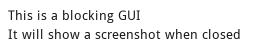

In [41]:
# run() should use the existing patched behavior (blocking + light theme + screenshot)
def simple_gui():
    imgui.text("This is a blocking GUI")
    imgui.text("It will show a screenshot when closed")

# This will block until the window is closed
immapp.nb.run(simple_gui, window_title="Blocking GUI", window_size_auto=True)

## Summary

The `immapp.nb` module provides:

- `immapp.nb.start()` - Start GUI non-blocking with notebook-friendly defaults
- `immapp.nb.stop()` - Stop the running GUI
- `immapp.nb.is_running()` - Check if GUI is running
- `immapp.nb.run()` - Blocking mode with screenshot (delegates to patched immapp.run)

All functions support the same three signatures as `immapp.run_async()`:
1. `(RunnerParams, AddOnsParams=None)`
2. `(SimpleRunnerParams, AddOnsParams=None)`
3. `(gui_function, **kwargs)` with addon parameters